# Notebook 44: Dilation tendency

The dilation-tendency of a fracture is defined as ([Ferrill et al., 1999](https://rock.geosociety.org/net/gsatoday/archive/9/5/pdf/i1052-5173-9-5-1.pdf)):

$$
T_d= \frac{\sigma_1-\sigma}{\sigma_1-\sigma_3}
$$

where $\sigma$ is the normal traction on the fracture. $T_d$ is a proxy for the tendency of a fracture to dilate in a given stress field.

If we know the principal stresses, magnitude and orientations, we can compute the normal, $\sigma$, and shear, $\tau$, tractions on the plane using the following equations (Ramsay, 1967):

$$
\begin{gathered}
\sigma=\sigma_1 l^2+\sigma_2 m^2+\sigma_3 n^2 \\
\tau^2=\left(\sigma_1-\sigma_2\right)^2 l^2 m^2+\left(\sigma_2-\sigma_3\right)^2 m^2 n^2+\left(\sigma_3-\sigma_1\right)^2 n^2 l^2
\end{gathered}
$$

where $l$, $m$ and $n$ are the direction cosines of the pole to the plane with respect to $\sigma_1$, $\sigma_2$ and $\sigma_3$, respectively.

## Python function

The function [dilation_tendency](../functions/dilation_tendency.py) computes the dilation tendency on a plane given a stress tensor. The stress is defined by the principal stresses magnitude and orientation. The plane is defined by its pole. The orientation of the principal stresses and the pole to the plane are given as direction cosines with respect to North-East-Down (NED).

## Application:

Let's compute the dilation tendency of the Vette fault in the Horda platform (North Sea). In [notebook 16](nb16_bestfit_plane.ipynb), we computed the orientations of the fault, both from manual interpretation and machine learning (ML) interpretation. Let's use these orientations to evaluate the tendency of the fault to dilate.

First, we need some information about the stress in the region. Table 2 of [Michie et al. (2022)](https://library.seg.org/doi/abs/10.1190/INT-2021-0077.1) contains this information:

<div align="center">

|  | Gradient (MPa/m) | Direction |
| -------- | ---------- | ---------- |
| SHmin | 0.0146 | 090 |
| SHmax | 0.0146 | 180 |
| Sv | 0.0215 | - |
| PP | 0.01 | - |

</div>

PP is pore pressure. Let's calculate the dilation tendency for all possible fault orientations and plot it on a stereonet and a Mohr Circle diagram. Let's use a depth of 3 km.

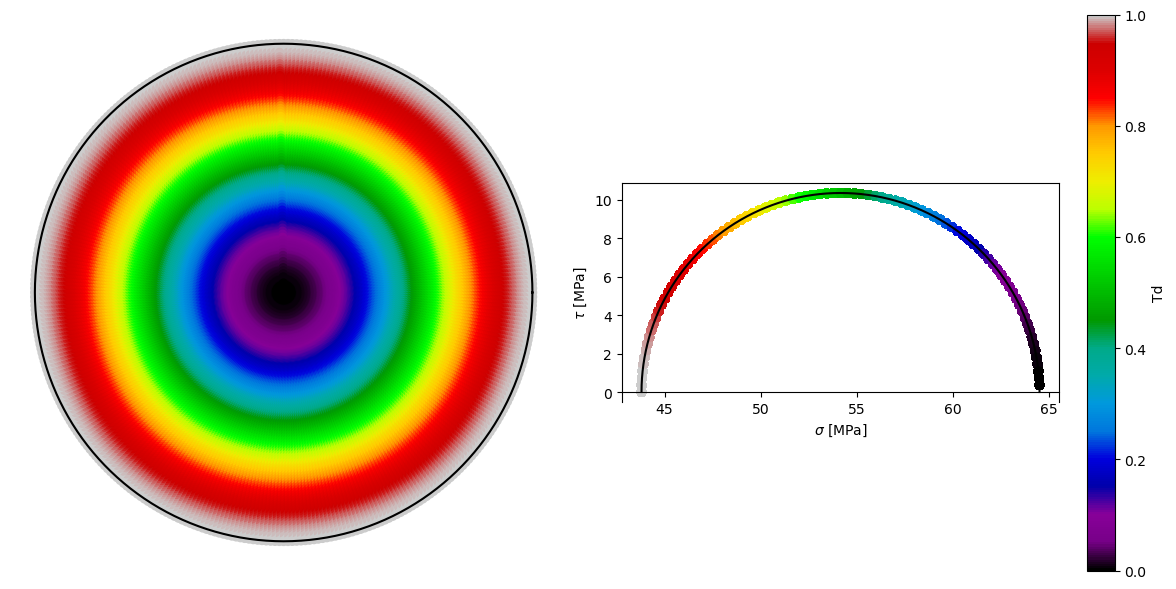

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# this makes visible our functions folder
import sys, os
sys.path.append(os.path.abspath(os.path.join("..", "functions")))

# import functions 
from pole import pole_from_plane
from st_coord_line import st_coord_line
from sph_to_cart import sph_to_cart
from dilation_tendency import dilation_tendency
# import class
from Circle import Circle

# principal stresses
p_stress = np.zeros((3,4))
p_stress[0,0] = 0.0215*3e3 # sigma 1
p_stress[1,0] = 0.0146*3e3 # sigma 2
p_stress[2,0] = 0.0146*3e3 # sigma 3

# direction cosines of principal stresses 
p_stress[0,1], p_stress[0,2], p_stress[0,3] = sph_to_cart(0, 90*np.pi/180)
p_stress[1,1], p_stress[1,2], p_stress[1,3] = sph_to_cart(180*np.pi/180, 0)
p_stress[2,1], p_stress[2,2], p_stress[2,3] = sph_to_cart(90*np.pi/180, 0)

# poles of all possible orientations
trends = np.radians(np.arange(0, 360)) 
plunges = np.radians(np. arange(0, 90))

# initialize arrays
pole = np.zeros(3) # direction cosines of pole
sn = np.zeros(trends.size * plunges.size) # normal traction for all poles
ss = np.zeros(trends.size * plunges.size) # shear traction for all poles
dt = np.zeros(trends.size * plunges.size) # dilation tendency for all poles
xp = np.zeros(trends.size * plunges.size) # x of poles in stereonet
yp = np.zeros(trends.size * plunges.size) # y  of poles in stereonet

counter = 0 # counter for pole number

for i in range(trends.size):
    for j in range(plunges.size):
        # direction cosines of pole
        pole[0], pole[1], pole[2] = sph_to_cart(trends[i], plunges[j])

        # normal and shear tractions, and dilation tendency
        sn[counter], ss[counter], dt[counter] = dilation_tendency(p_stress, pole)

        # coordinates of pole in equal stereonet
        xp[counter], yp[counter] = st_coord_line(trends[i], plunges[j], 1)
        
        counter += 1

# plot results 
fig, ax = plt.subplots(1,2,figsize=(12,6)) 

# stereonet
circle = Circle([0,0], 1)
x, y = circle.coordinates()
ax[0].plot(x, y, "k")
# plot the poles colored by dilation tendency
ax[0].scatter(xp, yp, c=dt, cmap="nipy_spectral")
# make axes equal and remove them
ax[0].axis("scaled")
ax[0].axis("off")

# Mohr Circle
center_x = (p_stress[0,0] + p_stress[2,0])/2
radius = (p_stress[0,0] - p_stress[2,0])/2
circle = Circle([center_x, 0], radius)
x, y = circle.coordinates(0, np.radians(180))
ax[1].plot(x, y, "k")
# plot the poles colored by dilation tendency
# and add colorbar, make limits 0 to 1.0
cbar =  ax[1].scatter(sn, ss, c=dt, cmap="nipy_spectral", vmin=0, vmax=1)
plt.colorbar(cbar, ax=ax[1], label="Td")
# axes labels
ax[1].set_xlabel(r"$\sigma$ [MPa]")
ax[1].set_ylabel(r"$\tau$ [MPa]")
# axes equal
ax[1].axis("scaled")
# move x-axis to zero
ax[1].spines["bottom"].set_position("zero")

# nice layout
fig.tight_layout()

plt.show()

Now, let's plot the manually interpreted Vette fault over the $T_d$  diagrams. Note that although the fault facets are not at the same depth and are therefore at different principal stres values, the principal stress ratios are constant. This means that the fault poles are correctly located in the Mohr Circle, but their $\sigma$ and $\tau$ values must be corrected for depth (remember that we chose 3 km depth).

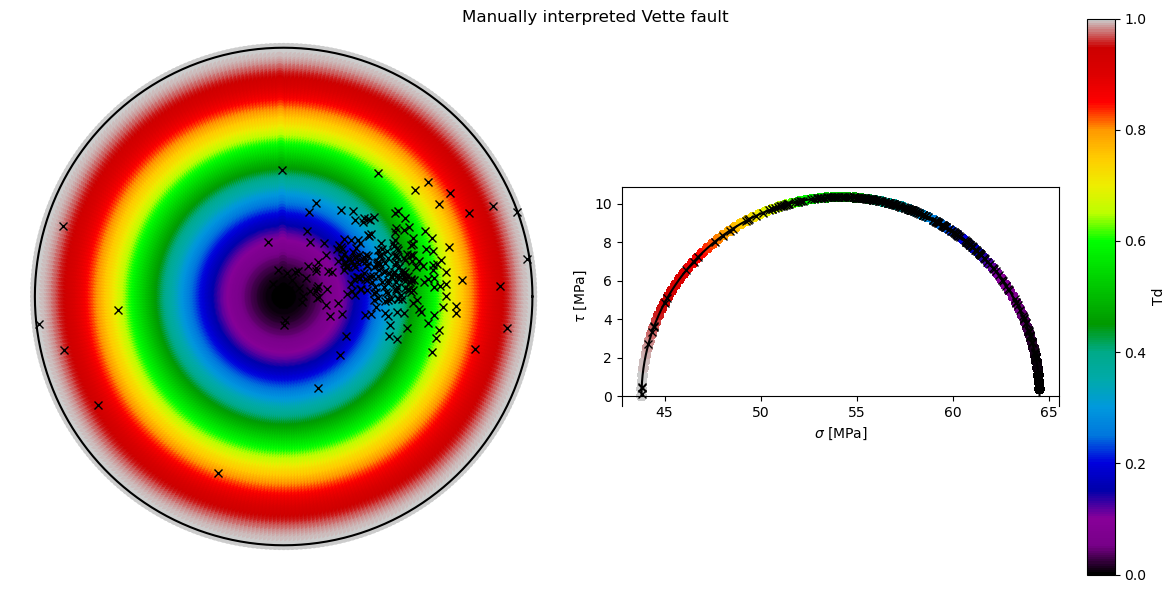

In [2]:
# read the orientation data
path = os.path.join("..", "data", "Vette_fault", "manual_orientations.txt")
data = np.loadtxt(path)
data = np.radians(data) # convert to radians

# initialize arrays
d_xp = np.zeros(data.shape[0]) 
d_yp = np.zeros(data.shape[0])
d_sn = np.zeros(data.shape[0]) 
d_ss = np.zeros(data.shape[0]) 

for i in range(data.shape[0]):
    # pole from plane
    trd, plg = pole_from_plane(data[i,0], data[i,1])

    # direction cosines of pole
    pole[0], pole[1], pole[2] = sph_to_cart(trd, plg)
    
    # normal and shear tractions
    d_sn[i], d_ss[i], _ = dilation_tendency(p_stress, pole)

    # coordinates of pole in equal stereonet
    d_xp[i], d_yp[i] = st_coord_line(trd, plg, 1)

# plot results in a stereonet and Mohr Cicle
fig, ax = plt.subplots(1,2,figsize=(12,6)) # figure

# stereonet
circle = Circle([0,0], 1)
x, y = circle.coordinates()
ax[0].plot(x, y, "k")
# plot the poles colored by dilation tendency
ax[0].scatter(xp, yp, c=dt, cmap="nipy_spectral")
# plot the poles of the Vette fault
ax[0].plot(d_xp, d_yp, 'kx')
# make axes equal and remove them
ax[0].axis("scaled")
ax[0].axis("off")

# Mohr Circle
center_x = (p_stress[0,0] + p_stress[2,0])/2
radius = (p_stress[0,0] - p_stress[2,0])/2
circle = Circle([center_x, 0], radius)
x, y = circle.coordinates(0, np.radians(180))
ax[1].plot(x, y, "k")
# plot the poles colored by dilation tendency
# and add colorbar
cbar =  ax[1].scatter(sn, ss, c=dt, cmap="nipy_spectral", vmin=0, vmax=1)
plt.colorbar(cbar, ax=ax[1], label="Td")
# plot the poles of the Vette fault
ax[1].plot(d_sn, d_ss, 'kx')
# axes labels
ax[1].set_xlabel(r"$\sigma$ [MPa]")
ax[1].set_ylabel(r"$\tau$ [MPa]")
# axes equal
ax[1].axis("scaled")
# move x-axis to zero
ax[1].spines["bottom"].set_position("zero")

# nice layout
fig.tight_layout()
# add figure title
fig.suptitle("Manually interpreted Vette fault")

plt.show()

And let's do the same for fault interpreted using machine learning (ML):

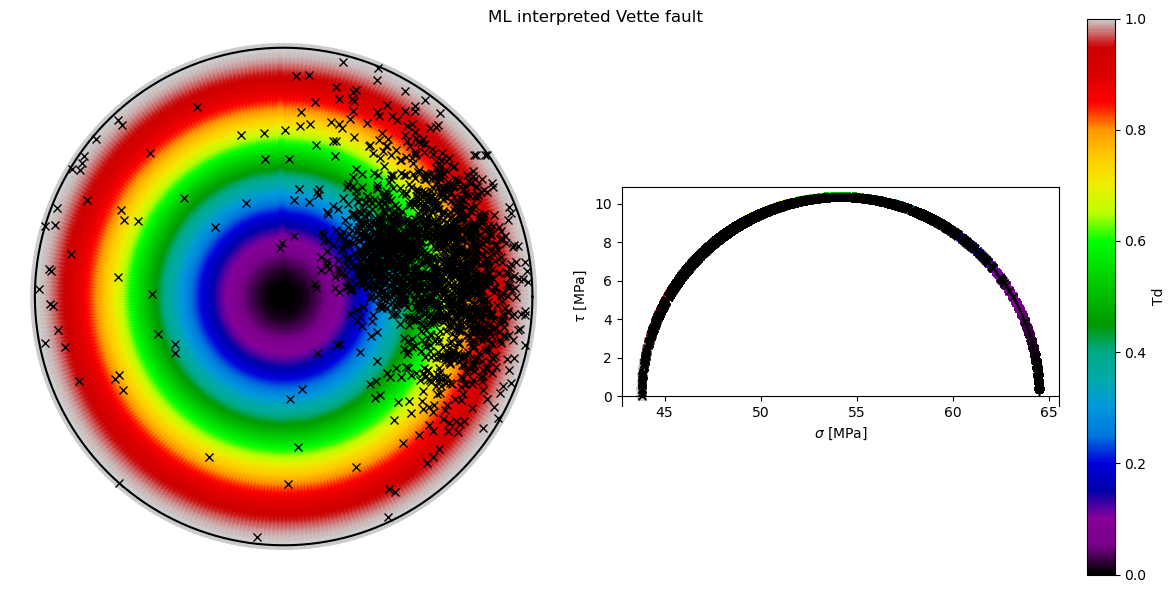

In [3]:
# read the orientation data
path = os.path.join("..", "data", "Vette_fault", "ML_orientations.txt")
data = np.loadtxt(path)
data = np.radians(data) # convert to radians

# initialize arrays
d_xp = np.zeros(data.shape[0]) 
d_yp = np.zeros(data.shape[0])
d_sn = np.zeros(data.shape[0]) 
d_ss = np.zeros(data.shape[0]) 

for i in range(data.shape[0]):
    # pole from plane
    trd, plg = pole_from_plane(data[i,0], data[i,1])

    # direction cosines of pole
    pole[0], pole[1], pole[2] = sph_to_cart(trd, plg)
    
    # compute normal and shear tractions
    d_sn[i], d_ss[i], _ = dilation_tendency(p_stress, pole)
    
    # compute of pole in equal stereonet
    d_xp[i], d_yp[i] = st_coord_line(trd, plg, 1)

# plot results in a stereonet and Mohr Cicle
fig, ax = plt.subplots(1,2,figsize=(12,6)) # figure

# stereonet
circle = Circle([0,0], 1)
x, y = circle.coordinates()
ax[0].plot(x, y, "k")
# plot the poles colored by dilation tendency
ax[0].scatter(xp, yp, c=dt, cmap="nipy_spectral")
# plot the poles of the Vette fault
ax[0].plot(d_xp, d_yp, 'kx')
# make axes equal and remove them
ax[0].axis("scaled")
ax[0].axis("off")

# Mohr Circle
center_x = (p_stress[0,0] + p_stress[2,0])/2
radius = (p_stress[0,0] - p_stress[2,0])/2
circle = Circle([center_x, 0], radius)
x, y = circle.coordinates(0, np.radians(180))
ax[1].plot(x, y, "k")
# plot the poles colored by dilation tendency
# and add colorbar
cbar =  ax[1].scatter(sn, ss, c=dt, cmap="nipy_spectral", vmin=0, vmax=1)
plt.colorbar(cbar, ax=ax[1], label="Td")
# plot the poles of the Vette fault
ax[1].plot(d_sn, d_ss, 'kx')
# axes labels
ax[1].set_xlabel(r"$\sigma$ [MPa]")
ax[1].set_ylabel(r"$\tau$ [MPa]")
# axes equal
ax[1].axis("scaled")
# move x-axis to zero
ax[1].spines["bottom"].set_position("zero")

# nice layout
fig.tight_layout()
# add figure title
fig.suptitle("ML interpreted Vette fault")

plt.show()